In [1]:
using Pkg
Pkg.activate(".")
Pkg.add("Plots")

using Plots

  Activating project at `~/Documents/GitHub/tmp/src`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/GitHub/tmp/src/Project.toml`
  No Changes to `~/Documents/GitHub/tmp/src/Manifest.toml`


# Newton's cup (1D ODE)

Imagine a cup containing coffee at some temperature $T$.
The surrounding environment (air, etc) is at some other _fixed_ temperature $T_s$ causing heat to flow away from the coffee when $T>T_s$ (and otherwise when $T<T_s$).
Newton's law of cooling (and heating) tells us that for some constant $r$ dependent on the properties of the cup including heat conductivity and the effective surface area of interaction, the temperature $T$ behaves following
\begin{equation}
\frac{dT}{dt} = - r(T-T_s)
\end{equation}
where $t$ is the time.

We can generalize this problem into a 1D ODE in the following form:
$$
\frac{du}{dt} = f(u,p,t)
$$
where $u$ is the generalized variable, $p$ holds the parameter values (may be a vector or an ordered list), and $t$ as the independent time parameter.

In [2]:
# Setting up parameters (2 params)
r = 1
Ts = 25.0 # in deg C, room with AC

# Packaging the parameters into one object, p::Vector..
p = [r,Ts] # set r = p[1] and Ts = p[2]

# Defining function according to the problem
f(T,p,t) = -p[1] * (T - p[2])

f (generic function with 1 method)

# Plotting a "complicated" function

We plot $f(T,p,t)$ vs $T$ to confirm.

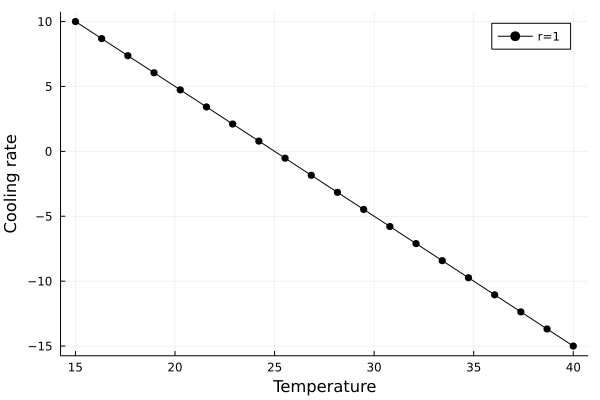

In [3]:
# Setting t = 0.0 since f(T,p,t) is independent of time
TRange = range(15,40; length=20) # try ?Base.range() for doc
dT_dt = [ f(T,p,0.0) for T in TRange ]

plt = plot( TRange, dT_dt # plot with basic feature
    ,linecolor=:black, marker=(:circle,:black)
    ,label="r=1"
)

# Enhancing resulting plot
plot!(plt
    ,xlabel="Temperature"
    ,ylabel="Cooling rate"
)

# Identifying input-output pairs

The ODE problem is usually taken as an input-output pair of objects containing other objects such as variables, parameters (including the independent variable typically as time).
In this case, we can use the following objects:
- `prob` : the problem object that completely described the ODE problem
- `soln` : the solutoin object returned by the Solver called via `solve()`
- `solvePls()` : the function object that solves the `prob`, essentially a regular object that _runs_ the Solver via `()`, just as `[]` accesses the _contents_ of the object.

**The Plan** is to be able to issue the following code to find the `soln` to any given `prob`:
```
soln = solvePls(prob)
```

Minimum contents:
- `prob` :: (`f`, `init`, `tspan`, `params`)
- `soln` :: (`t`, `u`), where `t` is the vector whose elements correspond to each elements of the vector of solution `u`.
- `solvePls()` : must run the Solve algorithm that generates and returns the `soln`

## Problem object

In [4]:
?MyProblem

search:

Couldn't find MyProblem
Perhaps you meant Module


No documentation found.

Binding `MyProblem` does not exist.


In [5]:
struct MyProblem
    f::Function
    u0
    tspan #expecting a Tuple
    p
end

In [6]:
# f and p are defined in the cell above

T0 = 80.0 # typical newly served coffee
trange = (0.0,10.0)#range(0,10;length=101) # use N+1 for length to add the ends
prob0 = MyProblem(f,T0,trange,p)

MyProblem(f, 80.0, (0.0, 10.0), [1.0, 25.0])

In [7]:
typeof(prob0)

MyProblem

In [8]:
@show prob0.p
@show prob0.u0;
@show prob0.tspan
@show prob0.f( 80.0, prob0.p, 0.0 );

prob0.p = [1.0, 25.0]
prob0.u0 = 80.0
prob0.tspan = (0.0, 10.0)
prob0.f(80.0, prob0.p, 0.0) = -55.0


## Solution object

In [9]:
?MySolution

search:

Couldn't find MySolution
Perhaps you meant position


No documentation found.

Binding `MySolution` does not exist.


In [10]:
struct MySolution
    t
    u
end

In [11]:
t = range(0.0,2π; length=101)
soln = MySolution( t, sin.(t) )

@show typeof(soln)
@show soln;

typeof(soln) = MySolution
soln = MySolution(0.0:0.06283185307179587:6.283185307179586, [0.0, 0.06279051952931337, 0.12533323356430426, 0.1873813145857246, 0.2486898871648548, 0.3090169943749474, 0.3681245526846779, 0.42577929156507266, 0.4817536741017153, 0.5358267949789967, 0.5877852522924731, 0.6374239897486896, 0.6845471059286886, 0.7289686274214116, 0.7705132427757893, 0.8090169943749475, 0.8443279255020151, 0.8763066800438636, 0.9048270524660196, 0.9297764858882513, 0.9510565162951535, 0.9685831611286311, 0.9822872507286886, 0.9921147013144779, 0.9980267284282716, 1.0, 0.9980267284282716, 0.9921147013144779, 0.9822872507286887, 0.9685831611286312, 0.9510565162951536, 0.9297764858882515, 0.9048270524660195, 0.8763066800438637, 0.8443279255020152, 0.8090169943749475, 0.7705132427757893, 0.7289686274214114, 0.6845471059286888, 0.6374239897486899, 0.5877852522924732, 0.5358267949789967, 0.4817536741017152, 0.4257792915650729, 0.36812455268467814, 0.3090169943749475, 0.2486898871648548

## Plotting the `soln0::MySolution`

In [12]:
plt = plot( soln ) #!! Fail since no method for this input pattern

LoadError: Cannot convert MySolution to series data for plotting

## Plotting the `soln0::MySolution`

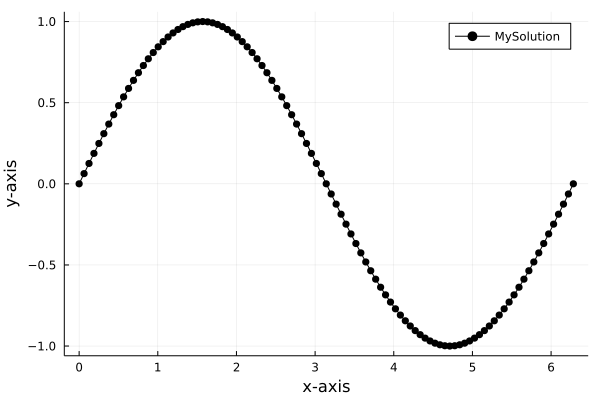

In [13]:
plt = plot( soln.t, soln.u
    ,lc=:black
    ,marker=(:circle,:black)
    ,label="MySolution"
    ,xlabel="x-axis"
    ,ylabel="y-axis"
)

# The `solvePls()` function object

We shall use the simplified Euler algorithm to generate a numerical solution to the `MyProblem` object.
Given that
$$
\frac{du}{dt} = f(u,p,t),
$$
an Euler approximation can be done by considering a finite time step $\Delta t$ and that
$$
\Delta u \approx f(u,p,t) \Delta t
$$
and that for each time step $\Delta t$, the value is updated as follows.
$$
u \leftarrow u + \Delta u.
$$

The `solvePls()` method is then:
1. Initialize values.
2. Update values via the Euler finite approximation.
3. Update local time parameter.
4. Loop back to Step 2 if not yet done.
5. Return the solution object.

In [14]:
function solvePls( prob::MyProblem; npoints=100 )
    # Ensuring one-to-one correspondence..
    u = [ prob.u0 ] # first entry of solution
    t = [ prob.tspan[1] ] # first entry of time param
    dt = (prob.tspan[2] - prob.tspan[1])/(npoints+1) #ensures clean end
    
    # Initializing..
    uold = prob.u0
    told = prob.tspan[1]
    
    # Looping steps 2 and 3..
    for _ in 1:npoints
        # Computing Euler step..
        unew = uold + dt*prob.f( uold, prob.p, told )
        tnew = told + dt
        
        # Collecting values..
        u = vcat(u,unew)
        t = vcat(t,tnew)
        
        # Exchanging values..
        uold = unew
        told = tnew
    end
    
    return MySolution(t,u)
end

solvePls (generic function with 1 method)

# Solving `prob::MyProblem`

In [41]:
soln0 = solvePls(prob0; npoints=40)

MySolution([0.0, 0.24390243902439024, 0.4878048780487805, 0.7317073170731707, 0.975609756097561, 1.2195121951219512, 1.4634146341463414, 1.7073170731707317, 1.951219512195122, 2.1951219512195124  …  7.5609756097561025, 7.804878048780493, 8.048780487804883, 8.292682926829274, 8.536585365853664, 8.780487804878055, 9.024390243902445, 9.268292682926836, 9.512195121951226, 9.756097560975617], [80.0, 66.58536585365854, 56.44259369422963, 48.77366840295411, 42.97521269491652, 38.5910144766442, 35.27613289697488, 32.76975901966393, 30.87469584413614, 29.441843199224888  …  25.009468379141993, 25.007159018375653, 25.005412916332812, 25.004092692837006, 25.003094475071883, 25.00233972505435, 25.00176906040695, 25.001337582258913, 25.00101134268357, 25.000764673736356])

## Solution plot

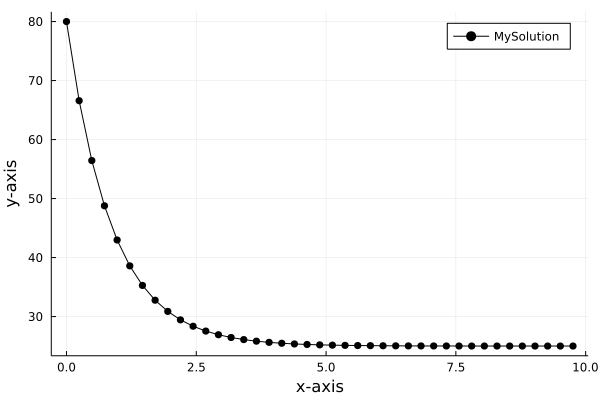

In [42]:
plt = plot( soln0.t, soln0.u
    ,lc=:black
    ,marker=(:circle,:black)
    ,label="MySolution"
    ,xlabel="x-axis"
    ,ylabel="y-axis"
#    ,yaxis=:log
)

# Using **Julia Packages**

👏👏👏👏👏👏👏👏👏!

Just like the [GNU Scientific Library `gsl`](https://www.gnu.org/software/gsl/) or the [Python GSL](https://pypi.org/project/gsl/), a collection or "suit" of packages are also made available for uniform and standard Julia interfaces (pattern).

The equivalent of [Python `numpy`](https://numpy.org) in Julia is the Julia itself because the `numpy` equivalence packages can already be readily installed and added into the Julia base.

In [17]:
Pkg.add("DifferentialEquations")
using DifferentialEquations

   Resolving package versions...
  No Changes to `~/Documents/GitHub/tmp/src/Project.toml`
  No Changes to `~/Documents/GitHub/tmp/src/Manifest.toml`


# Using the `DifferentialEquations.jl`

The [`DifferentialEquations.jl`](https://diffeq.sciml.ai/stable/) "_is a suite for numerically solving differential equations written in Julia and available for use in Julia, Python, and R.
The purpose of this package is to supply efficient Julia implementations of solvers for various differential equations._"
Like `Plots`, it _wraps_ various ODE solvers into one interface.

In [18]:
T0 = 80.0 # best serving coffee temperature
tspan = (0.0,10.0)
prob = ODEProblem( f, T0, tspan, p )

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 10.0)
u0: 80.0

### _Contents_ of `prob::ODEProblem`

The field names of the types of `prob` are the usual input needed to solve the problem.

In [19]:
typeof(prob)

ODEProblem{Float64, Tuple{Float64, Float64}, false, Vector{Float64}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(f), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}

In [20]:
fieldnames(typeof(prob))

(:f, :u0, :tspan, :p, :kwargs, :problem_type)

## Default `Solver` object

The solution for the given problem is here using the default `Solver` object.

In [21]:
soln = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 15-element Vector{Float64}:
  0.0
  0.10778207622444223
  0.36852921904082964
  0.7074497816337273
  1.1188868830005836
  1.6089178236553825
  2.1764993654786933
  2.8286091944383824
  3.573480814663654
  4.427291879963558
  5.412319050803496
  6.561885828475071
  7.923740732382182
  9.570094742789202
 10.0
u: 15-element Vector{Float64}:
 80.0
 74.38027777332957
 63.046306289199556
 52.10948512236951
 42.96539585451809
 36.005768711096664
 31.239167593989116
 28.2503444957246
 26.543347175657722
 25.657257771246034
 25.2455695046644
 25.077927396598774
 25.020099882666383
 25.003999677078056
 25.002602075968433

In [47]:
fieldnames(typeof(soln))

(:u, :u_analytic, :errors, :t, :k, :prob, :alg, :interp, :alg_choice, :dense, :tslocation, :destats, :retcode)

In [22]:
typeof(soln)

OrdinaryDiffEq.ODECompositeSolution{Float64, 1, Vector{Float64}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Float64}}, ODEProblem{Float64, Tuple{Float64, Float64}, false, Vector{Float64}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(f), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, CompositeAlgorithm{Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rosenbrock23{0, false, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, nothing}}, OrdinaryDiffEq.AutoSwitchCache{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, Rosenbrock23{0, false, Nothing, typeof(OrdinaryDiffEq.DEFAULT_PRECS), Val{:forward}, true, no

### Plotting the solution our way

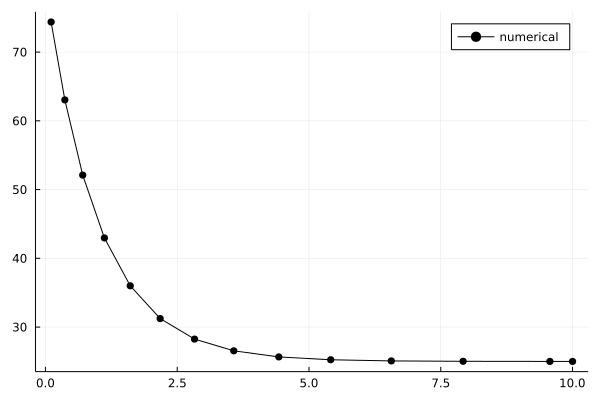

In [24]:
plt = plot(soln.t[2:end], soln.u[2:end]
    ,lc=:black,marker=(:circle,:black)
    ,label="numerical"
)

## Plotting with interpolation

A comparison with our Euler solution is also made.

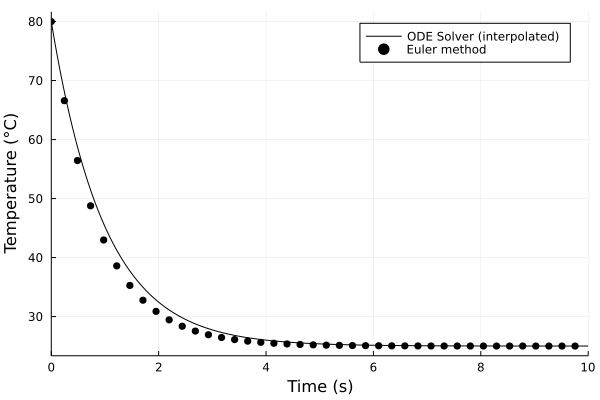

In [51]:
plt = plot(soln
    ,lc=:black
    ,label="ODE Solver (interpolated)"
)

scatter!(plt, soln0.t, soln0.u
    ,markershape=:circle,mc=:black
    ,label="Euler method"
)

plot!(plt
    ,xlabel="Time (s)"
    ,ylabel="Temperature (°C)"
#    ,yaxis=:log
)

# Discussions